# Using XGBoost regressor on Indicators, ARIMA and FFT of ohlcv data

The goal of this notebook is to apply XGBoost to set of fetures from ohlcv indicators, fft results and arima predictions to test feature importance.

## Table of content

- [Project Setup](#project-setup)
    * [Dependencies](#dependencies)
    * [ccxt-fetch-ohlcv](#ccxt-fetch-ohlcv)
    * [caching-helper](#caching-helper)
    * [pull-data](#pull-data)
- [Collect features](#collect-features)
    * [FFT](#fft)
    * [ARIMA](#arima)
    * [Technical indicators](#ti)
    * [Features overview](#features-eng)
- [Features importance with XGBoost regressor](#features-importance)
- [Conclusion](#conclusion)


<div id='project-setup'/>

# Project Setup

<div id='dependencies'/>

In [1]:
import pickle
from pathlib import Path
from collections import deque

In [53]:
import numpy as np
import pandas as pd

In [54]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [55]:
import ccxt

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
import warnings
warnings.filterwarnings('ignore')

After importing lets create a watermark

In [90]:
%load_ext watermark

In [92]:
%watermark -v -m -p ccxt,matplotlib,pandas,numpy,statsmodels,sklearn,xgboost,watermark

CPython 3.6.7
IPython 5.0.0

ccxt 1.17.529
matplotlib 3.0.2
pandas 0.23.4
numpy 1.15.4
statsmodels 0.9.0
sklearn 0.20.2
xgboost 0.81
watermark 1.8.0

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.15.0-43-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


<div id='ccxt-fetch-ohlcv'/>

## Define ccxt fetch_ohlcv function
Get an ohlcv data from public api endpoint.
Conmvert it to pandas dataframe with columns and human readable timestamp

In [58]:
def get_ohlcv(exchange, symbol, timeframe):
    '''Get an ohlcv data from an exchange
    and return it as pandas dataframe.
    timeframe = 1m 5m 15m 30m 1h 2h... etc.'''
    raw_data = exchange.fetch_ohlcv(symbol, timeframe)
    ohlcv_data = pd.DataFrame(raw_data)
    ohlcv_data.columns = ["date", "open", "high", "low", "close", "volume"]
    ohlcv_data['date'] = pd.to_datetime(ohlcv_data['date'], unit='ms')
    return ohlcv_data.set_index('date')

<div id='caching-helper'/>

## Define CCXT Helper Function
To assist with this data retrieval we'll define a function to download and cache datasets from an exchanges.
It will use sub-folder whick name we can change below.

In [59]:
def get_ccxt_data(exchange, symbol, timeframe):
    '''Download and cache ccxt dataseries'''
    local_folder = Path.cwd()
    data_folder = "raw_data"
    file_name = '{}_{}_{}.pkl'.format(exchange.name, symbol, timeframe).replace('/','-')
    cache_path = Path(local_folder, data_folder, file_name)
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {}_{}_{} from cache'.format(exchange.name, symbol, timeframe))
    except (OSError, IOError) as e:
        print('Downloading {} {} from {}'.format(symbol, timeframe, exchange.name,))
        df = get_ohlcv(exchange, symbol, timeframe)
        df.to_pickle(cache_path)
        print('Cached {}_{}_{} at {}'.format(exchange.name, symbol, timeframe, cache_path))
    return df

<div id='pull-data'/>

## Pull Binance Exchange Pricing Data

For this notebook we will take 1d candles but you can try other precisions offered by your data provider.

In [60]:
exchange = ccxt.binance()
symbol = 'BTC/USDT'
timeframe = '1d'

While we prepare all wrapping and http calls in above functions we just say:

In [61]:
btc_usdt_price_binance = get_ccxt_data(exchange,symbol,timeframe)

Loaded Binance_BTC/USDT_1d from cache


Lets explore what we got.

In [62]:
btc_usdt_price_binance['close'].head(3)

date
2017-09-09    4258.81
2017-09-10    4130.37
2017-09-11    4208.47
Name: close, dtype: float64

In [63]:
print('There are {} number of days in the dataset.'.format(btc_usdt_price_binance.shape[0]))

There are 500 number of days in the dataset.


Next, we'll generate a simple chart as a quick visual verification that the data looks correct.  

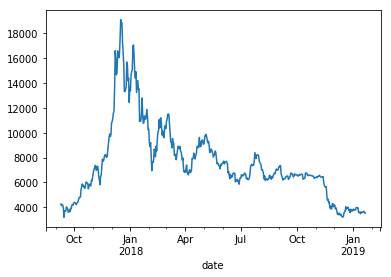

In [64]:
btc_usdt_price_binance['close'].plot(figsize = (12, 6))

<div id='collect-features'/>

# Collect features

In [ ]:
dataset_total_df = pd.DataFrame(btc_usdt_price_binance['close'])

<div id='fft'/>

## FFT 

We will use Fourier transforms to extract global and local trends, and also to denoise it a little. So let's see how it works.

In [66]:
close_data = pd.DataFrame(btc_usdt_price_binance['close'])
close_data['datetime'] = pd.to_datetime(close_data.index, unit='d')
data_FT = pd.DataFrame(close_data[['datetime', 'close']].values)
data_FT.columns = ['Date', 'Close']

In [67]:
close_fft = np.fft.rfft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

plt.figure(figsize=(14, 7), dpi = 100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_] = 0
    dataset_total_df['fft{}'.format(num_)] = np.fft.irfft(fft_list_m10)

<Figure size 1400x700 with 0 Axes>

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2017-09-09 to 2019-01-21
Data columns (total 4 columns):
close    500 non-null float64
fft3     500 non-null float64
fft6     500 non-null float64
fft9     500 non-null float64
dtypes: float64(4)
memory usage: 19.5 KB


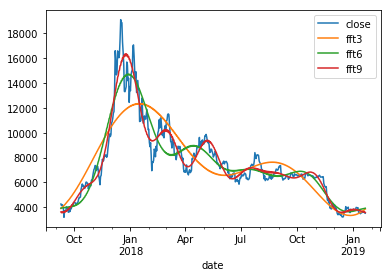

In [68]:
dataset_total_df.info()
dataset_total_df.plot(figsize = (12, 6))

As you see the more components from the Fourier transform we use the closer the approximation function is to the real stock price (the 9 components transform is closer to the original function - the red and the blue lines almost overlap). We use Fourier transforms for the purpose of extracting long- and short-term trends so we will use the transforms with 3, 6, and 9 components. You can infer that the transform with 3 components serves as the long term trend.

Another technique used to denoise data is call wavelets. Wavelets and Fourier transform gave similar results so we will only use Fourier transforms.

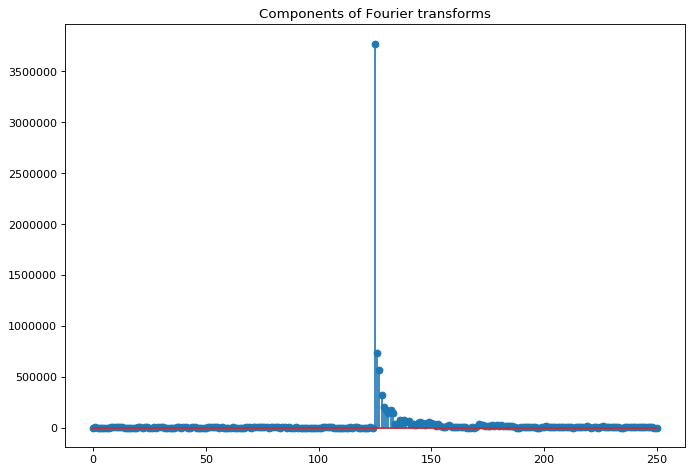

In [69]:
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Components of Fourier transforms')
plt.show()

<div id='arima'/>

## ARIMA

ARIMA is a technique for predicting time series data. We will show how to use it, and althouth ARIMA will not serve as our final prediction, we will use it as a technique to denoise the stock a little and to (possibly) extract some new patters or features.

In [70]:
series = pd.DataFrame(close_data['close'])
series.index = pd.to_datetime(series.index, unit='D')

In [71]:
model = ARIMA(series, order=(5, 1, 0), missing='drop')
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  499
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3762.616
Method:                       css-mle   S.D. of innovations            455.442
Date:                Mon, 21 Jan 2019   AIC                           7539.232
Time:                        21:30:50   BIC                           7568.720
Sample:                    09-10-2017   HQIC                          7550.804
                         - 01-21-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.6730     22.743     -0.074      0.941     -46.248      42.902
ar.L1.D.close     0.0818      0.044      1.841      0.066      -0.005       0.169
ar.L2.D.close     0.0006      0.044     

In [72]:
output = model_fit.forecast()
yhat = output[0]
print('Next predicted value {0:.2f}'.format(float(yhat)))

Next predicted value 3527.31


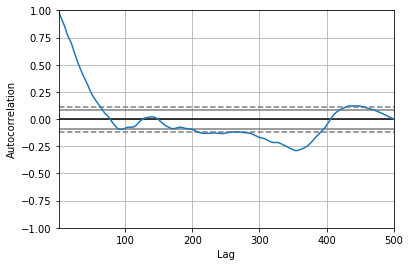

In [73]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)

In [74]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0), missing='drop')
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 29642.647


Plot the predicted (from ARIMA) and real prices


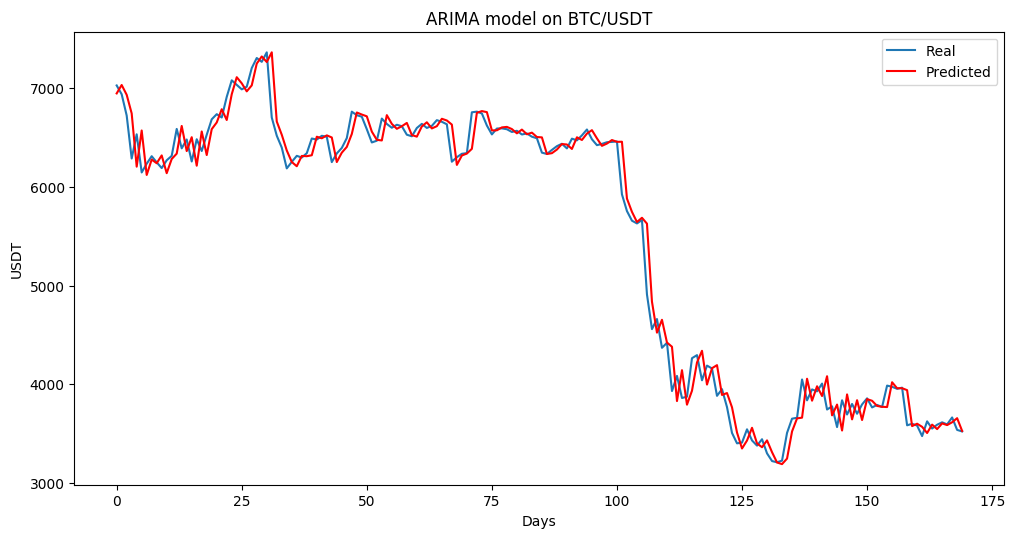

In [75]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USDT')
plt.title('ARIMA model on BTC/USDT')
plt.legend()
plt.show()

<div id='ti'/>

## Technical indicators

We will create technical indicators for BTC/USDT on Binance.

In [76]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['close'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['close'].ewm(span=26).mean() # pd.ewma(dataset['close'], span=26, freq="D")
    dataset['12ema'] = dataset['close'].ewm(span=12).mean() # pd.ewma(dataset['close'], span=12, freq="D")
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] =  dataset['close'].rolling(20).std()# pd.stats.moments.rolling_std(dataset['close'],20)
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['close'].ewm(com=0.5).mean()
    
    return dataset

In [78]:
dataset_total_df = get_technical_indicators(series)

<div id='features-eng'/>

## Features overview

In [79]:
print('Total dataset has {} samples, and {} features.'.format(dataset_total_df.shape[0], 
                                                              dataset_total_df.shape[1]))

Total dataset has 500 samples, and 10 features.


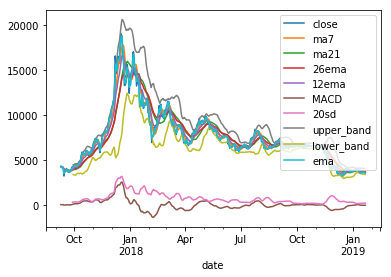

In [80]:
dataset_total_df.plot(figsize = (12, 6))

<div id='features-importance'/>

# Feature importance with XGBoost

Having our features we have to consider whether all of them are really indicative of the direction BTC will take. There are many ways to test feature importance, but the one we will apply uses XGBoost, because it gives one of the best results in both classification and regression problems.

In [93]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['close']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.665)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)


In [94]:
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_total_df)

Build XGB regressor

In [95]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

Traing the regressors and check result

In [102]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

In [97]:
eval_result = regressor.evals_result()

In [98]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

Let's plot the training and validation errors in order to observe the training and check for overfitting (there isn't overfitting).

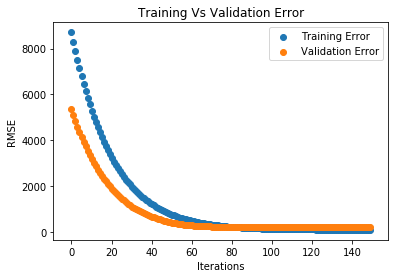

In [99]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

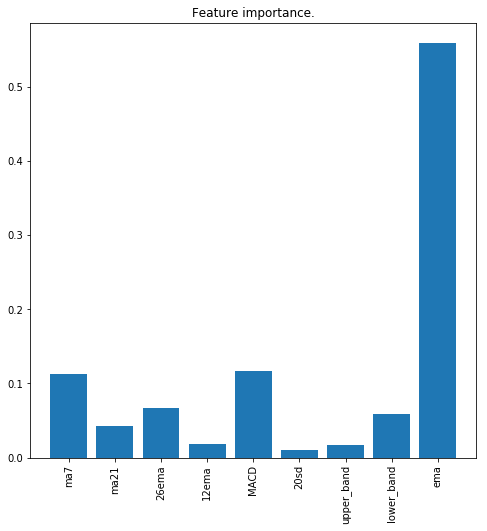

In [100]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Feature importance.')
plt.show()

<div id='conclusion'/>

## Conclusion

We construct nice aproximations with some popoular methods such as Fourier Free Trnasform and so called Technical indicators(popular among traders mean aproximations) into pandas dataframe, fit and evaluate results from XGBoost regressor, we can see that popularity of this methods are correlated with our results.
Dont forget that we do that for pothethic "1d" rounded candles while you can use this method to evaluate any kind of time-series data features.